In [2]:
import os
import math
import numpy as np
from typing import Any

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from matplotlib.colors import to_rgb
import seaborn as sns

## tqdm for progress bars
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter

# Torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12_jax"

print("Device:", jax.devices())

Device: [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)]


In [38]:
def image_to_numpy(img):
    img = np.array(img, dtype=np.int32)
    img = img[..., None]
    return img

train_dataset = MNIST(root=DATASET_PATH, train=True, transform=image_to_numpy, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))
test_set = MNIST(root=DATASET_PATH, train=False,
                 transform=image_to_numpy, download=True)

In [41]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False,
                             drop_last=False, num_workers=4, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False,
                              drop_last=False, num_workers=4, collate_fn=numpy_collate)

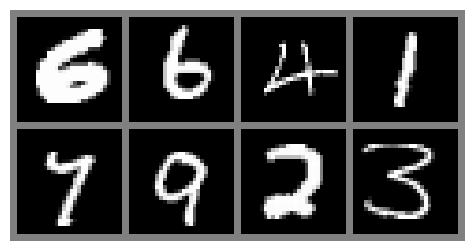

In [69]:
def show_imgs(imgs):
    imgs = jax.device_get(imgs)
    if isinstance(imgs, (list, tuple)):
        imgs = np.stack(imgs, axis=0)
    num_imgs = imgs.shape[0]
    if num_imgs < 4 or num_imgs % 4 == 0:
        nrow = min(num_imgs, 4)
        ncol = int(math.ceil(num_imgs/nrow))
    else:
        nrow = num_imgs
        ncol = 1
    imgs = np.pad(imgs, pad_width=[(0,0), (1,1), (1,1), (0,0)], constant_values=128)
    imgs = np.reshape(imgs, (nrow, ncol, *imgs.shape[1:]))
    imgs = np.transpose(imgs, (1, 2, 0, 3, 4))
    imgs = np.reshape(imgs, (imgs.shape[0]*imgs.shape[1], imgs.shape[2]*imgs.shape[3], -1))
    imgs = np.pad(imgs, pad_width=[(1,1), (1,1), (0,0)], constant_values=128)
    imgs = np.squeeze(imgs, axis=-1)
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(imgs, interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [180]:
class MaskedConvolution(nn.Module):
    c_out : int
    mask : np.ndarray
    dilation : int = 1

    @nn.compact
    def __call__(self, x):
        # Flax's convolution module already supports masking
        # The mask must be the same size as kernel
        # => extend over input and output feature channels
        if len(self.mask.shape) == 2:
            mask_ext = self.mask[...,None,None]
            print(x.shape[-1])
            mask_ext = jnp.tile(mask_ext, (1, 1, x.shape[-1], self.c_out))
        else:
            mask_ext = self.mask
        # Convolution with masking
        x = nn.Conv(features=self.c_out,
                    kernel_size=self.mask.shape[:2],
                    kernel_dilation=self.dilation,
                    mask=mask_ext)(x)
        return x

In [209]:
class VerticalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1
    
    def setup(self):
        mask = np.ones((self.kernel_size, self.kernel_size), dtype=np.float32)
        mask[self.kernel_size // 2 + 1: , :] = 0
        if self.mask_center:
            mask[self.kernel_size // 2, :] = 0
        self.conv = MaskedConvolution(
            self.c_out, mask=mask, dilation=self.dilation
        )
        
    def __call__(self, x):
        return self.conv(x)

In [210]:
class HorizontalStackConvolution(nn.Module):
    c_out : int
    kernel_size : int
    mask_center : bool = False
    dilation : int = 1

    def setup(self):
        mask = np.ones((1, self.kernel_size), dtype=np.float32)
        mask[0,self.kernel_size//2+1:] = 0
        if self.mask_center:
            mask[0,self.kernel_size//2] = 0

        self.conv = MaskedConvolution(c_out=self.c_out,
                                      mask=mask,
                                      dilation=self.dilation)
    def __call__(self, x):
        return self.conv(x)

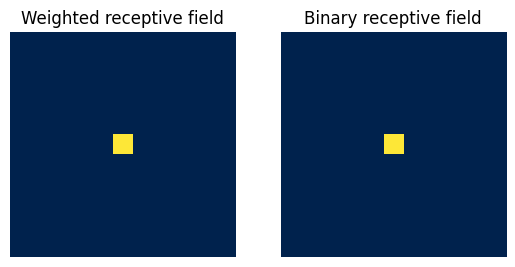

In [211]:
inp_img = np.zeros((1, 11, 11, 1), dtype=np.float32)

def show_center_recep_field(img, apply_fn):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    grad_fn = jax.grad(lambda inp: apply_fn(inp)[0,inp.shape[1]//2,inp.shape[2]//2][0])
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)
    
    # Plot receptive field
    img = img_grads[0,...,0]
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2, img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()

show_center_recep_field(inp_img, lambda x: x)

1
1


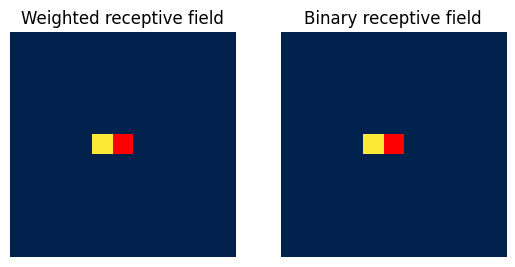

In [212]:
horiz_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=True)

init_params = lambda params: jax.tree_map(lambda x: jnp.full(x.shape, (0 if len(x.shape) == 1 else 1), dtype=x.dtype), params)
horiz_params = horiz_conv.init(random.PRNGKey(0), inp_img)
horiz_params = init_params(horiz_params)
# Apply horizontal convolution
horiz_conv = horiz_conv.bind(horiz_params)
show_center_recep_field(inp_img, lambda inp: horiz_conv(inp))

1
1


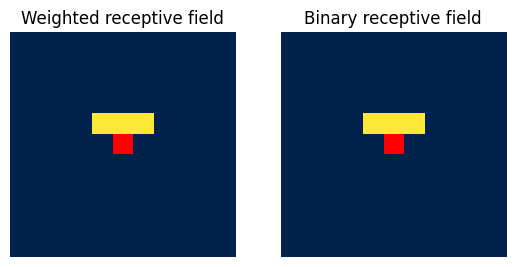

In [213]:
vert_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=True)
vert_params = vert_conv.init(random.PRNGKey(0), inp_img)
vert_params = init_params(vert_params)
vert_conv = vert_conv.bind(vert_params)
show_center_recep_field(inp_img, lambda inp: vert_conv(inp))

1
1


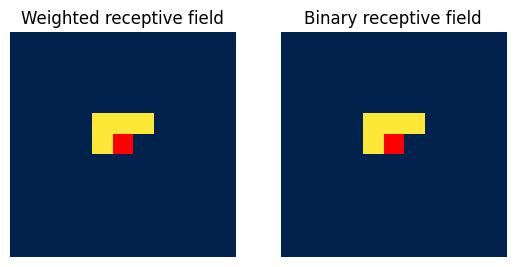

In [214]:
show_center_recep_field(inp_img, lambda inp: vert_conv(inp) + horiz_conv(inp))

Layer 2
1
1
1
1


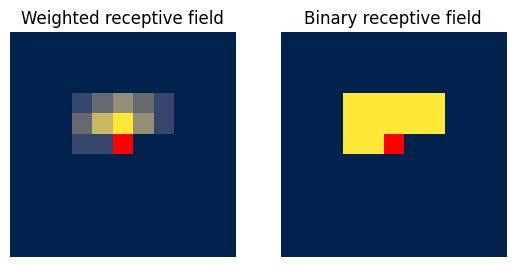

Layer 3
1
1
1
1
1
1


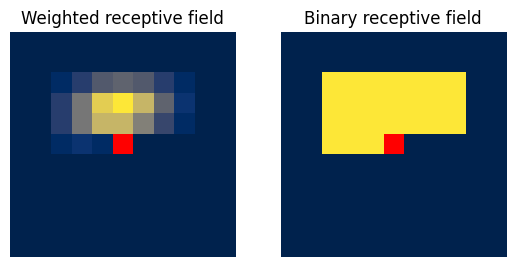

Layer 4
1
1
1
1
1
1
1
1


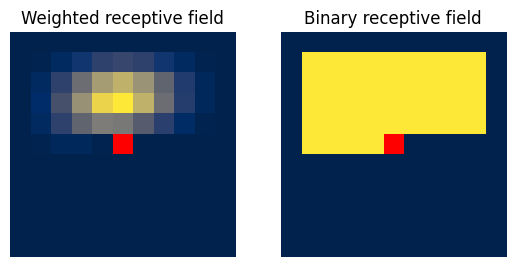

Layer 5
1
1
1
1
1
1
1
1
1
1


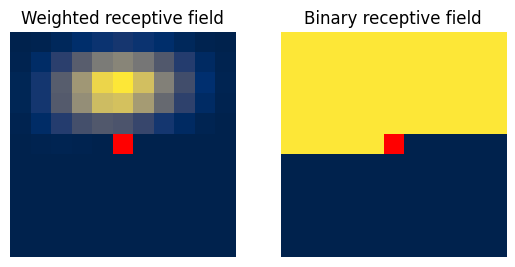

In [215]:
horiz_noc_conv = HorizontalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
vert_noc_conv = VerticalStackConvolution(c_out=1, kernel_size=3, mask_center=False)
horiz_noc_conv = horiz_noc_conv.bind(horiz_params)
vert_noc_conv = vert_noc_conv.bind(vert_params)

# We reuse our convolutions for the several layers with same parameters just for visualization.
def num_layer_network(inp, num_layers):
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    for _ in range(num_layers-1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

for layer_count in range(2, 6):
    print(f"Layer {layer_count}")
    show_center_recep_field(inp_img, lambda inp: num_layer_network(inp, layer_count)[0])